### CIFAR-10 Using Pytorch

In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import numpy as np

In [2]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='../Data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
# torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [6]:
for images,labels in train_loader:
    break

In [7]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

Label: [2 1 4 6 9 5 3 4 8 0]
Class:  bird   car  deer  frog truck   dog   cat  deer  ship plane


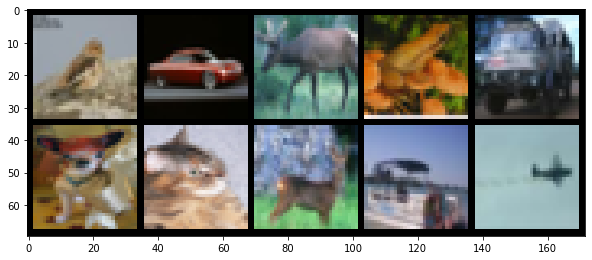

In [8]:
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [9]:
class convnet(nn.Module):
    
    def __init__(self):
        super().__init__()
        # input dims - (b,32,32,3)
        self.conv3_32 = nn.Conv2d(3, 32, 3, 1) # channels_in =3, # filters = 32 (3,3) stride =1
        self.conv32_32 = nn.Conv2d(32,32, 3, 1) # channels_in =16, # filters = 32 (3,3) stride =1
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.drop_4 = nn.Dropout2d(p=0.4)
        self.conv32_64 = nn.Conv2d(32,64,3,1)
        self.conv64_64 = nn.Conv2d(64,64,3,1)
        self.fc1 = nn.Linear(5*5*64,512)
        self.drop_5 = nn.Dropout2d(p=0.5)
        self.fc2 = nn.Linear(512,10)
        
    
    def forward(self,X):
        
        X = F.relu(self.conv3_32(X)) # dims 32,32,3 c-> 30,30,32 
        X = F.relu(self.conv32_32(X)) # 30,30,32 c-> 28,28,32
        X = self.pool(X) # 15,15,32 
        X = self.drop_4(X)
        
        X = F.relu(self.conv32_64(X)) # 13,13,64
        X = F.relu(self.conv64_64(X)) # 11,11,64
        X = self.pool(X) # 5,5,64
        X = self.drop_4(X)
        
        X = X.view(-1,5*5*64)

        X = F.relu(self.fc1(X))
        X = self.drop_5(X)
        X = F.relu(self.fc2(X))
        
        return F.log_softmax(X, dim=1)

        
        
        
        
        
        

        

In [11]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)  # changed from (1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)   # changed from (4*4*16) to fit 32x32 images with 3x3 filters
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [12]:
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [13]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [14]:
count_parameters(model)

   162
     6
   864
    16
 69120
   120
 10080
    84
   840
    10
______
 81302


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
import time
start = time.perf_counter() # starts a counter 

epochs = 12
train_correct = []
test_correct = []
train_losses = []
test_losses = []

for i in range(epochs):
    trn_corr = 0 
    tst_corr = 0
    
    for b, (x_train,y_train) in enumerate(train_loader):
        b += 1
        
        # forward pass
        y_pred = model(x_train)
        loss = criterion(y_pred,y_train)
        
        # tally 
        predictions = torch.max(y_pred.data,1)[1]
        batch_corr = (predictions == y_train).sum()
        trn_corr += batch_corr
        
        # back propagation 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # printing the interim status 
        if b%1000 == 0: 
            print(f'epoch {i:2} batch: {b:4} [{10*b:6}/50000] loss: {loss.item():10.2f}  accuracy: {trn_corr.item()*100/(10*b):7.3f}% ')
        
    # record losses
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    with torch.no_grad():
        for b, (x_test,y_test) in enumerate(test_loader):
            
            #on test set
            y_val = model(x_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test) # test loss
    test_losses.append(loss)
    test_correct.append(tst_corr)
            
    
elapsed = time.perf_counter() - start # elapsed time calculation

epoch  0 batch: 1000 [ 10000/50000] loss:       1.81  accuracy:  27.990% 
epoch  0 batch: 2000 [ 20000/50000] loss:       1.88  accuracy:  34.205% 
epoch  0 batch: 3000 [ 30000/50000] loss:       0.82  accuracy:  37.403% 
epoch  0 batch: 4000 [ 40000/50000] loss:       1.73  accuracy:  39.675% 
epoch  0 batch: 5000 [ 50000/50000] loss:       1.33  accuracy:  41.522% 
epoch  1 batch: 1000 [ 10000/50000] loss:       1.18  accuracy:  52.070% 
epoch  1 batch: 2000 [ 20000/50000] loss:       0.70  accuracy:  52.110% 
epoch  1 batch: 3000 [ 30000/50000] loss:       1.59  accuracy:  52.963% 
epoch  1 batch: 4000 [ 40000/50000] loss:       0.85  accuracy:  53.572% 
epoch  1 batch: 5000 [ 50000/50000] loss:       1.36  accuracy:  54.314% 
epoch  2 batch: 1000 [ 10000/50000] loss:       1.31  accuracy:  58.840% 
epoch  2 batch: 2000 [ 20000/50000] loss:       1.55  accuracy:  59.115% 
epoch  2 batch: 3000 [ 30000/50000] loss:       0.71  accuracy:  59.213% 
epoch  2 batch: 4000 [ 40000/50000] lo

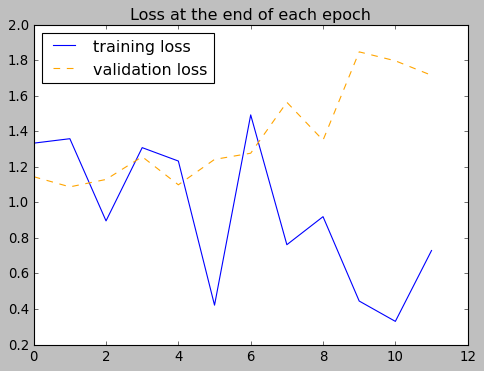

In [107]:
plt.style.use('classic')
plt.figure(figsize=(7,5))
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss',color='orange',ls='--')
plt.title('Loss at the end of each epoch')
plt.legend(loc='upper left');

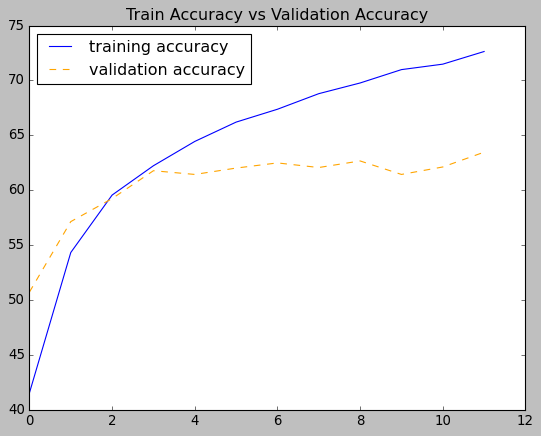

In [48]:
plt.title('Train Accuracy vs Validation Accuracy')
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy',ls='--',color='orange')
plt.legend(loc='upper left')

In [53]:
from sklearn.metrics import classification_report, confusion_matrix

10000

In [71]:
test_load = DataLoader(test_data,batch_size=test_data.data.shape[0],)

In [81]:
with torch.no_grad():
    correct = 0
    for x_test,y_test in test_load:
        
        y_val = model(x_test)
        _, predicted = y_val.max(1)
        
        correct += (predicted == y_test ).sum()
      
print(f"Test Accuracy {correct.item()}/{len(test_data)} : {correct.item()*100/(len(test_data))}%")
accuracy = correct.item()*100/ (len(test_data))   
        

Test Accuracy 6346/10000 : 63.46%


In [83]:
print(class_names)
print(classification_report(predicted,y_test))

['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
              precision    recall  f1-score   support

           0       0.69      0.66      0.68      1050
           1       0.73      0.74      0.74       987
           2       0.50      0.57      0.53       890
           3       0.49      0.45      0.47      1095
           4       0.53      0.61      0.57       868
           5       0.53      0.54      0.54       980
           6       0.71      0.72      0.72       985
           7       0.68      0.70      0.69       962
           8       0.80      0.66      0.72      1205
           9       0.68      0.70      0.69       978

    accuracy                           0.63     10000
   macro avg       0.63      0.64      0.63     10000
weighted avg       0.64      0.63      0.64     10000



In [84]:
report = '''
['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
              precision    recall  f1-score   support

           0       0.69      0.66      0.68      1050
           1       0.73      0.74      0.74       987
           2       0.50      0.57      0.53       890
           3       0.49      0.45      0.47      1095
           4       0.53      0.61      0.57       868
           5       0.53      0.54      0.54       980
           6       0.71      0.72      0.72       985
           7       0.68      0.70      0.69       962
           8       0.80      0.66      0.72      1205
           9       0.68      0.70      0.69       978

    accuracy                           0.63     10000
   macro avg       0.63      0.64      0.63     10000
weighted avg       0.64      0.63      0.64     10000




'''

In [94]:
confmat = pd.DataFrame(confusion_matrix(predicted,y_test))
confmat.index = class_names
confmat.columns = class_names

Text(0.5, 1.0, 'Confusion Matrix')

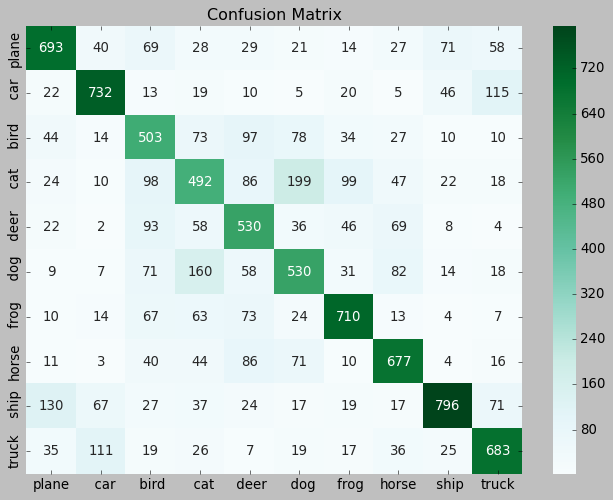

In [104]:
plt.figure(figsize=(10,7))
sns.heatmap(confmat,annot=True,fmt='d',cmap='BuGn')
plt.title('Confusion Matrix')

### Miscellaneous

In [108]:
import os
path = '../samples/'
overview_path = '../samples/overview.txt'
eval_path  = '../samples/evaluate.txt'

if os.path.exists(path):

    print('samples dir, exists..checking for dictionaries existence..')

    if os.path.exists(overview_path) and os.path.exists(eval_path):
        print('Data exists. no need of overwritting.')
    else:
        print("overview and eval doesn't exist, proceed to step-2")

else:
    print("samples/ dir is non-existent, Establishing one..")
    os.mkdir(path) # samples directory 


samples dir, exists..checking for dictionaries existence..
Data exists. no need of overwritting.


In [110]:
# desc-----string
# project_name-----string
# framework-----string
# prediction_type-----string
# network_type-----string
# architecture-----model()
# layers-----int
# hidden_units-----int
# activations-----string(list)
# epochs-----int
# metrics-----string(list)
# loss-----string
# optimiser-----string
# learning_rate-----float
# batch_size-----int/string
# train_performance-----float
# test_performance-----float
# classification_report-----string
# elapsed-----float
# summary-----string
# ipynb-----path
# plots-----path

In [113]:
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [125]:
synopsis = '''My Analogy behind the worse performance of pytorch compared to keras is the change in network architecture because, as a novice learner of pytorch I'm still figuring out how to implement 'SAME' padding in Pytorch without which the dimensions of the image decreases ridiculously with each convolutions and pooling, so it sort of forced me to use complex architechtures as I did with keras'''

In [127]:
synopsis

"My Analogy behind the worse performance of pytorch compared to keras is the change in network architecture because, as a novice learner of pytorch I'm still figuring out how to implement 'SAME' padding in Pytorch without which the dimensions of the image decreases ridiculously with each convolution, so it sort of forced me to use complex architechtures as I did with keras"

In [140]:
desc = '''The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The classes include various cars, ships, deers, dogs and cats, trucks etc.'''
project_name = 'CIFAR-10'
framework = 'Pytorch'
prediction_type = 'Multi-Class Classification of 10 Classes'
network_type = 'Convolutional Neural Network'
architecture = str(model)
layers = 5
hidden_units = 'None'
activations = "['relu','softmax']"
epochs = 12
metrics = 'Accuracy'
loss = 'Categorical Cross-Entropy'
optimiser = 'Adam'
learning_rate = '0.001'
batch_size = 10
train_performance = '72.63%'
test_performance = '63.46%'
classification_report = report
elapsed = '5.3 Mins, runtime: local'
summary = synopsis
ipynb = './Projects/CIFAR10/Pytorch/CIFAR10-Pytorch.pdf'
plots = './Projects/CIFAR10/Pytorch/Plots'

In [141]:
var = ['desc','project_name', 'framework','prediction_type','network_type',
    'architecture','layers','hidden_units','activations','epochs',
    'metrics','loss','optimiser','learning_rate','batch_size','train_performance','test_performance','classification_report','elapsed','summary'
    ,'ipynb','plots']
param = {}
for val in var:

    try:
        param[val] = eval(val)

    except:
        param[val] = val

In [142]:
param

{'desc': 'The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The classes include various cars, ships, deers, dogs and cats, trucks etc.',
 'project_name': 'CIFAR-10',
 'framework': 'Pytorch',
 'prediction_type': 'Multi-Class Classification of 10 Classes',
 'network_type': 'Convolutional Neural Network',
 'architecture': 'ConvolutionalNetwork(\n  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))\n  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))\n  (fc1): Linear(in_features=576, out_features=120, bias=True)\n  (fc2): Linear(in_features=120, out_features=84, bias=True)\n  (fc3): Linear(in_features=84, out_features=10, bias=True)\n)',
 'layers': 5,
 'hidden_units': 'None',
 'activations': "['relu','softmax']",
 'epochs': 12,
 'metrics': 'Accuracy',
 'loss': 'Categorical Cross-Entropy',
 'optimiser': 'Adam',
 'learning_rate': '0.001',
 'batch_size': 10,
 'train_perform

In [143]:
import pickle
file = open("artefacts.txt", "wb")
dictionary = param
pickle.dump(dictionary, file)
file.close()